# Running This Notebook

To run this notebook, you will need to have [tensorflow](https://www.tensorflow.org/install/docker) installed. When installing tensorflow, it is optional whether or not you want to use GPU to significantly speed up computations. This is not absolutely necessary to simply run this notebook, the code will run fine, but highly recomended if you plan on running the training stage of the model.

In [1]:
import os
import time
import numpy as np
from PIL import Image
import tensorflow as tf
import keras.backend as K
from keras.models import Model
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from keras.initializers import RandomNormal

2021-12-15 01:52:25.186079: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-15 01:52:25.186116: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Load Data

When tensorflow reads images, it likes to keep them in tensors that are batches of images. Batches are used to speed up the training of models. The tensors from batches are larger, but fewer tensor operations need to be done.

Also note, that unlike numpy arrays, tensorflow data sets are not directly stored in memory, as they are sometimes too big. Instead they specify a data pipeline.

Found 20 files belonging to 1 classes.
Found 20 files belonging to 1 classes.


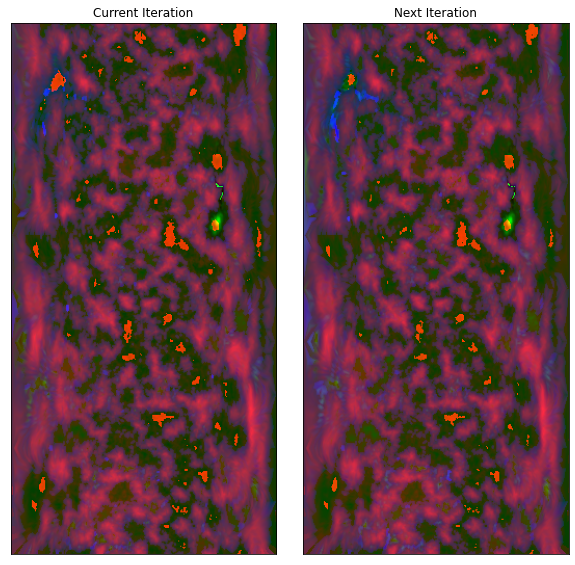

In [23]:
#Function for reading data from our image directories
def getBatchDataset(imageDir, imageHeight, imageWidth, batch_size):
    return tf.keras.utils.image_dataset_from_directory(
        imageDir,
        labels=None,
        seed=123,
        image_size=(imageHeight, imageWidth),
        batch_size=batch_size)

#Image parameters
batch_size = 4
imageWidth = 256
imageHeight = 512

#Image directories
featuresDir = './ImageTrainingData/Features'
targetsDir = './ImageTrainingData/Targets'

#Load data, extract a batch of each dataset, and extract an image from each batch
featureData = getBatchDataset(featuresDir, imageHeight, imageWidth, batch_size)
targetData = getBatchDataset(targetsDir, imageHeight, imageWidth, batch_size)

featureBatch = next(iter(featureData))
targetBatch = next(iter(targetData))

featureImage = featureBatch[2].numpy()
targetImage = targetBatch[2].numpy()


#Plot Training Data
fig, axis = plt.subplots(1, 2)
fig.set_figheight(10)
fig.set_figwidth(10)
axis[0].imshow(featureImage.astype(np.uint8))
axis[1].imshow(targetImage.astype(np.uint8))
axis[0].set_title('Current Iteration')
axis[1].set_title('Next Iteration')
axis[0].set_xticks([])
axis[0].set_yticks([])
axis[1].set_xticks([])
axis[1].set_yticks([])
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

# First Attempt at Making a GAN

Here we walk through our first attempt at making a Generative Adversarial Network to simulate erosion. A good amount of this section is based on [this GAN tutorial for tensorflow](https://www.tensorflow.org/tutorials/generative/dcgan), but is modified to suit our data.

Although the first attempt gave terrible results, it did help me learn the basics of making a GAN and helped me be more familiar with more advanced tensorflow models.

### Generator Model

The generator model bellow is based the tensorflow tutorial that I was following, with some adjustments made to better suit it our data, and further changes made based on trial and error.

In [3]:
#Here we define the structure of the generator model
def getGeneratorModel(imageWidth, imageHeight):
    model = tf.keras.Sequential()
    
    #A few convolution layers for interpreting input image
    model.add(layers.Conv2D(64, 4, activation='relu'))
    model.add(layers.MaxPooling2D())
    model.add(layers.Conv2D(32, 3, activation='relu'))
    model.add(layers.MaxPooling2D())
    model.add(layers.Flatten())
    
    model.add(layers.Dense(16 * 8 * 3, activation='relu'))
    model.add(layers.Reshape((16, 8, 3)))
    
    #Some layers for generating images
    model.add(layers.Conv2DTranspose(64, (10, 10), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(32, (10, 10), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(16, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(8, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    #Final output layer
    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    return model

As of now, our model has not been trained yet, so it's output should be a noisy image.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 512, 256, 3)
(4, 512, 256, 3)


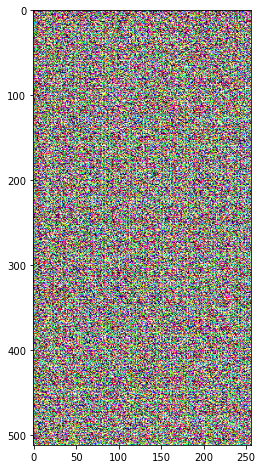

In [4]:
#Generate some random results with our untrained model
batch = next(iter(featureData))
generator = getGeneratorModel(imageWidth, imageHeight)
generatedImageBatch = generator(batch, training=False)

#Check that the output images has the desired dimensions
print(batch.shape)
print(generatedImageBatch.shape)

image = generatedImageBatch[2].numpy()
image /= np.max(image)
image *= 255

#Visualize results
plt.figure(figsize=(10, 8))
plt.imshow(image)
plt.show()

### Discriminator Model

The discriminator model will try to distinguish between generated and fake images. It returns a value between $[-1, 1]$ depending on how confident it is that the image is real $1$ or fake $-1$ (created by our generator).

In [5]:
def getDiscriminatorModel(imageWidth, imageHeight):
    model = tf.keras.Sequential()
    
    #Two convolutional layers
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    #Output either a 1 or 0 for real or fake
    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    return model

Using our image generated from our untrained generator network, we test that our untrained discriminator model is working.

In [6]:
discriminator = getDiscriminatorModel(imageWidth, imageHeight)
decision = discriminator(generatedImageBatch)
print(decision[2])

tf.Tensor([0.00236868], shape=(1,), dtype=float32)


### Loss Functions

Loss functions in machine learning are used to measure how well a particular model is performing. During the training stage, our model will adjust it's parameters in an attempt to minimize it's loss function. We will need a loss function for both the generator and discriminator models.

In [7]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

#Checkpoints incase our model training is interrupted
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

### Defining the Training Loop

Here we specify the training loop

In [8]:
#Training loop of GAN
@tf.function
def train_step(inputBatch, outputBatch):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        
        #Generate next simulation iterator using our generator model
        generatedImages = generator(inputBatch, training=True)
        
        #Pass real and fake images to discriminator
        real_output = discriminator(outputBatch, training=True)
        fake_output = discriminator(generatedImages, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [9]:
def train(featureData, targetData, epochs, generator):
    testBatch = next(iter(featureData))
    
    for epoch in range(epochs):
        start = time.time()
        for inputBatch, outputBatch in zip(featureData, targetData):
            train_step(inputBatch, outputBatch, generator)

        # Produce images for the GIF as you go
        generate_and_save_images(generator, epoch + 1, testBatch)

        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    # Generate after the final epoch
    generate_and_save_images(generator, epochs, testBatch)

def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    plt.imshow(predictions[0].numpy())
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))

Change to true to train the model. If you don't feel like waiting for the training to finish however, we provide some results images bellow. As we can see, the inital results after our first attempt are really bad, and does not show erosion at all.

In [10]:
if False:
    epochs = 5
    train(featureData, targetData, epochs)

Example results image:
<div>
<img src="ResultsImages/Trial1/image_at_epoch_0003.png" width="900">
</div>

# GAN Model Based on Eric Guerin's Paper

### Generator Model
After testing, the above model did not give desirable results. To fix this, we will see how the following GAN by [Eric Guerin et. al.](https://hal.archives-ouvertes.fr/hal-01583706/file/tog.pdf) performs on our data. We will modify various parameters and layers to make the GAN work with our data.

- Just like our above model, they implement a encoder layer using a sequence of convolutional layers, and an decoder with a sequence of deconvolutional layers.
- In addition, they also use skip layers to connect the convolutional layers with deconvolutional layers of the same resolution.
- Their graphics card has 12 Gb of dedicated graphics RAM, I only have 8 Gb, so I may have to work around this. I should still be able to get reasonable results though.

The code bellow is copied and pasted from the [*nanoxas/sketch-to-terrain* Github](https://github.com/nanoxas/sketch-to-terrain/blob/master/model.py), and adjusted for our purposes. The original code is the same code provided by Eric Guerin et. al's paper.

In [11]:
#Here we define the structure of the generator model
def getInspiredGeneratorModel(imageWidth, imageHeight):
    
    #Input layer
    inputs = layers.Input((imageHeight, imageWidth, 3))
    
    #A few convolutional layers with maxpooling
    #This is the encoder part of the model that interprets the input image
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(conv4)
    pool4 = layers.MaxPooling2D(pool_size=(2, 2))(conv4)
    conv5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(conv5)
    
    #Their last convolution layer in their encoder seems to have skip layer with noise introduced to it
    #Noise is often used to avoid the overfiting of a machine learning model
    #noise = layers.Input((K.int_shape(conv5)[1], K.int_shape(conv5)[2], K.int_shape(conv5)[3]))
    #conv5 = layers.Concatenate()([conv5, noise])
    
    #From my understanding, upsampling is used to increase the weight of data in the minority class
    #Skip layer (connects conv4 layer directly to up6 layer), and more convolutional layers
    up6 = layers.Conv2D(512, 2, activation='relu', padding='same')(layers.UpSampling2D(size=(2, 2))(conv5))
    merge6 = layers.Concatenate()([conv4, up6])
    conv6 = layers.Conv2D(512, 3, activation='relu', padding='same')(merge6)
    conv6 = layers.Conv2D(512, 3, activation='relu', padding='same')(conv6)
    
    up7 = layers.Conv2D(256, 2, activation='relu', padding='same')(layers.UpSampling2D(size=(2, 2))(conv6))
    merge7 = layers.Concatenate()([conv3, up7])
    conv7 = layers.Conv2D(256, 3, activation='relu', padding='same')(merge7)
    conv7 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv7)
    
    up8 = layers.Conv2D(128, 2, activation='relu', padding='same')(layers.UpSampling2D(size=(2, 2))(conv7))
    merge8 = layers.Concatenate()([conv2, up8])
    conv8 = layers.Conv2D(128, 3, activation='relu', padding='same')(merge8)
    conv8 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv8)
    
    up9 = layers.Conv2D(64, 2, activation='relu', padding='same')(layers.UpSampling2D(size=(2, 2))(conv8))
    merge9 = layers.Concatenate()([conv1, up9])
    conv9 = layers.Conv2D(64, 3, activation='relu', padding='same')(merge9)
    conv9 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv9)
    conv9 = layers.Conv2D(32, 3, activation='relu', padding='same')(conv9)
    conv10 = layers.Conv2D(3, 1, activation='tanh')(conv9)
    
    #Create and return the final model
    model = Model(inputs=inputs, outputs=conv10)
    return model

From the output bellow, we can clearly see the output of the Unet model above maintains many of the features of the input data, which is definetely something we will want. Note that considering that the model has not been trained yet, the results already look much more promising compared to our first attempt.

In [12]:
#Generate some random results with our untrained model
batch = next(iter(featureData))
generator = getInspiredGeneratorModel(imageWidth, imageHeight)
generator.summary()
generatedImageBatch = generator(batch, training=False)

#Check that the output images has the desired dimensions
print(batch.shape)
print(generatedImageBatch.shape)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_4 (Conv2D)              (None, 512, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_5 (Conv2D)              (None, 512, 256, 64  36928       ['conv2d_4[0][0]']               
                                )                                                             

 conv2d_22 (Conv2D)             (None, 256, 128, 12  147584      ['conv2d_21[0][0]']              
                                8)                                                                
                                                                                                  
 up_sampling2d_3 (UpSampling2D)  (None, 512, 256, 12  0          ['conv2d_22[0][0]']              
                                8)                                                                
                                                                                                  
 conv2d_23 (Conv2D)             (None, 512, 256, 64  32832       ['up_sampling2d_3[0][0]']        
                                )                                                                 
                                                                                                  
 concatenate_3 (Concatenate)    (None, 512, 256, 12  0           ['conv2d_5[0][0]',               
          

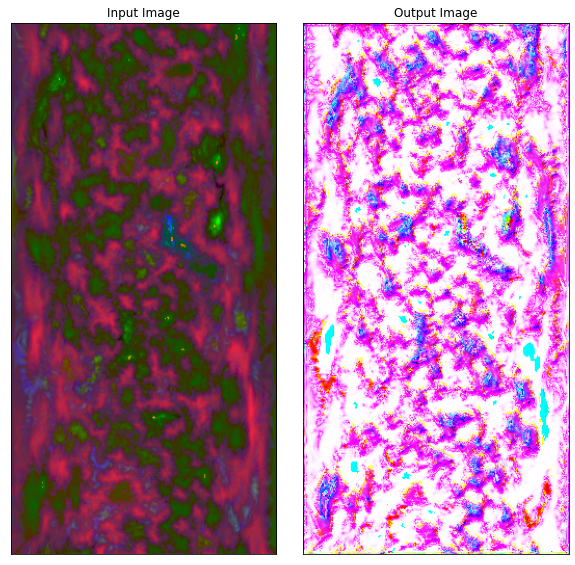

In [13]:
#Plot both input and output image examples of our model
inputImage = batch[2].numpy()
outImage = generatedImageBatch[2].numpy() * 256

fig, axis = plt.subplots(1, 2)
fig.set_figheight(10)
fig.set_figwidth(10)
axis[0].imshow(inputImage.astype(np.uint8))
axis[1].imshow(outImage.astype(np.uint8))
axis[0].set_title('Input Image')
axis[1].set_title('Output Image')
axis[0].set_xticks([])
axis[0].set_yticks([])
axis[1].set_xticks([])
axis[1].set_yticks([])
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

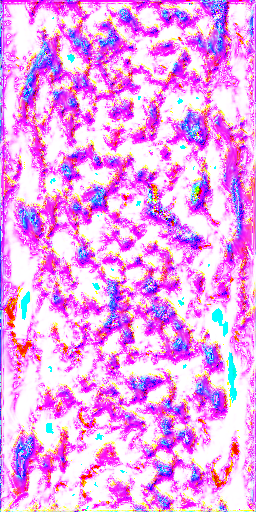

In [14]:
#Code for outputing results as an image (and not an imshow plot)
image = generatedImageBatch[2].numpy() * 256
#image = batch[2].numpy()
img = Image.fromarray(image.astype(np.uint8))
img.show()

## Discussion

Note that the above images are the results of passing our input data through the yet un-trained generator model. The model currently has 31,050,243 trainable parameters, which are initiated by random numbers. Notice how the output images do indeed have a resamblance to the input images, which is a result of the skip layers. This resamblance leads me to believe that the model is clearly capable of learning our training data.

From the code bellow, we can see that passing a batch of 32 images through our model takes about 0.015 seconds using my GTX 2080 GPU. This means we can expect our final algorithm (after training) to take less than half a milisecond per iteration to simulate erosion. If this works as intended, then this will be by far the fastest erosion algorithm that I am aware of, by multiple orders of magnitude.

Note that if your installation of tensorflow does not have access to a GPU, then your code might take significantly longer to run this cell with a CPU instead. For me, a batch of 32 images takes about 27 seconds to run on my CPU, less than 1 second per iteration.

In [15]:
start = time.time()
generatedImageBatch = generator(batch, training=False)
print(time.time() - start)

3.306983232498169


The code bellow is the original code from [Eric Guerin et. al.'s](https://github.com/nanoxas/sketch-to-terrain/blob/master/model.py) github.

<details>
<summary> 
    <p style="font-style: italic; color:blue;">
        Click here to see original code
    </p>
</summary>
<br> <p style="font-style: italic;">

    from keras.layers import *
    from keras.models import Model
    from keras.initializers import RandomNormal
    import keras.backend as K

    def UNet(shape):

        inputs = Input(shape)
        conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
        conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
        pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
        conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
        conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
        pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
        conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
        conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
        pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
        conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
        conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
        pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

        conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
        conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)
        noise = Input((K.int_shape(conv5)[1], K.int_shape(conv5)[2], K.int_shape(conv5)[3]))
        conv5 = Concatenate()([conv5, noise])

        up6 = Conv2D(
            512,
            2,
            activation='relu',
            padding='same')(
            UpSampling2D(
                size=(
                    2,
                    2))(conv5))
        merge6 = Concatenate()([conv4, up6])
        conv6 = Conv2D(512, 3, activation='relu', padding='same')(merge6)
        conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)

        up7 = Conv2D(
            256,
            2,
            activation='relu',
            padding='same')(
            UpSampling2D(
                size=(
                    2,
                    2))(conv6))
        merge7 = Concatenate()([conv3, up7])
        conv7 = Conv2D(256, 3, activation='relu', padding='same')(merge7)
        conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)

        up8 = Conv2D(
            128,
            2,
            activation='relu',
            padding='same')(
            UpSampling2D(
                size=(
                    2,
                    2))(conv7))
        merge8 = Concatenate()([conv2, up8])
        conv8 = Conv2D(128, 3, activation='relu', padding='same')(merge8)
        conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)

        up9 = Conv2D(
            64,
            2,
            activation='relu',
            padding='same')(
            UpSampling2D(
                size=(
                    2,
                    2))(conv8))
        up9 = ZeroPadding2D(((0, 1), (0, 1)))(up9)
        merge9 = Concatenate()([conv1, up9])
        conv9 = Conv2D(64, 3, activation='relu', padding='same')(merge9)
        conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)
        conv9 = Conv2D(32, 3, activation='relu', padding='same')(conv9)
        conv10 = Conv2D(1, 1, activation='tanh')(conv9)

        model = Model(input=[inputs, noise], output=conv10)
        model.summary()
        return model

</p></details>

### Discriminator Model

**The following section is not finished**

Similarly, we will use a discriminator model taken from Eric Guerin's paper, and see how well it performs. According to their paper, their discriminator model returns decisions for multiple patches of a single input image. Which is a bit different to what we had before.

In [16]:
def getInspiredDiscriminatorModel(imageHeight, imageWidth):
    
    #Create inputs of initial and generated image to discrimate, and combine them
    init = RandomNormal(stddev=0.02)
    initialImage = layers.Input(shape=(imageHeight, imageWidth, 3))
    generatedImage = layers.Input((imageHeight, imageWidth, 3))
    combinedImages = layers.Concatenate()([initialImage, generatedImage])
    
    #Main structure of the discriminator neural network model
    d = layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(combinedImages)
    d = layers.LeakyReLU(alpha=0.2)(d)
    d = layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(d)
    d = layers.LeakyReLU(alpha=0.2)(d)
    d = layers.Conv2D(256, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(d)
    d = layers.LeakyReLU(alpha=0.2)(d)
    d = layers.Conv2D(512, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(d)
    d = layers.LeakyReLU(alpha=0.2)(d)
    d = layers.Conv2D(512, (4, 4), padding='same', kernel_initializer=init)(d)
    x = layers.LeakyReLU(alpha=0.2)(d)
    output = layers.Conv2D(1, (4, 4), padding='same', activation='sigmoid', kernel_initializer=init)(d)
    
    #Create the model and return it
    model = Model([initialImage, generatedImage], output)
    return model

We test that the discriminator model gives a desirable output.

In [17]:
generator = getInspiredGeneratorModel(imageWidth, imageHeight)
discriminator = getInspiredDiscriminatorModel(imageHeight, imageWidth)
discriminator.summary()

#batch = next(iter(featureData))
#generatedImageBatch = generator(batch, training=False)

#decision = discriminator((batch, generatedImageBatch))
#print(decision[2])

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 512, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_4 (InputLayer)           [(None, 512, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 concatenate_8 (Concatenate)    (None, 512, 256, 6)  0           ['input_3[0][0]',                
                                                                  'input_4[0][0]']          

Their code also contains the following third model, which was not mentioned in their paper. Not sure what it is used for, but I'll leave it here just incase I might need it when messing around.

In [18]:
def mount_discriminator_generator(generator, discriminator, image_shape):
    discriminator.trainable = False
    input_gen = layers.Input(shape=image_shape)
    #input_noise = layers.Input(shape=(14, 14, 1024))
    
    gen_out = generator([input_gen])
    output_d = discriminator([gen_out, input_gen])
    model = Model(inputs=[input_gen], outputs=[output_d, gen_out])
    return model

#Create a mountDiscriminator and print summary of model
mountDiscriminator = mount_discriminator_generator(generator, discriminator, (imageHeight, imageWidth, 3))
mountDiscriminator.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 512, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 model_1 (Functional)           (None, 512, 256, 3)  31050243    ['input_5[0][0]']                
                                                                                                  
 model_2 (Functional)           (None, 32, 16, 1)    6962625     ['model_1[0][0]',                
                                                                  'input_5[0][0]']                
                                                                                            

Loss functions for measuring how well our models are performing.

In [19]:
#Loss function for the discriminator model
def inspiredDiscriminatorLoss(realOutput, fakeOutput):
    crossEntropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    realLoss = crossEntropy(tf.ones_like(realOutput), realOutput)
    fakeLoss = crossEntropy(tf.zeros_like(fakeOutput), fakeOutput)
    totalLoss = realLoss + fakeLoss
    return totalLoss

#Loss function for the generator model
def inspiredGeneratorLoss(fakeOutput):
    crossEntropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    return crossEntropy(tf.ones_like(fakeOutput), fakeOutput)

Make sure that our loss functions are return results of a reasonable type.

Found 20 files belonging to 1 classes.
Found 20 files belonging to 1 classes.
2.2912366
3.6493678


/opt/conda/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


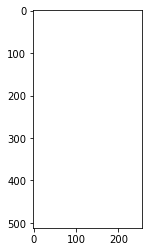

In [20]:
#Load data and extract a batch
featureData = getBatchDataset(featuresDir, imageHeight, imageWidth, batch_size)
targetData = getBatchDataset(targetsDir, imageHeight, imageWidth, batch_size)
featureBatch = next(iter(featureData))
targetBatch = next(iter(targetData))

#Generate next simulation iterator using our currently untrained generator model
generator = getInspiredGeneratorModel(imageWidth, imageHeight)
generatedImageBatch = generator(featureBatch, training=False)
ones = tf.ones_like(generatedImageBatch)

#Pass real and fake images to discriminator
real_output = discriminator((featureBatch, targetBatch), training=False)
fake_output = discriminator((featureBatch, generatedImageBatch), training=False)

#Get losses
discriminatorLoss = inspiredDiscriminatorLoss(real_output, fake_output)
generatorLoss = inspiredGeneratorLoss(fake_output)



print(generatorLoss.numpy())
print(discriminatorLoss.numpy())

image = generatedImageBatch[0].numpy()
oneImage = ones[0].numpy()

plt.imshow(oneImage)

In [21]:
#Define the training loop for a single training epoch
@tf.function
def trainInspiredNetwork(inputBatch, outputBatch, generator, discriminator):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        
        #Generate next simulation iterator using our generator model
        generatedImages = generator(inputBatch, training=True)
        
        #Pass real and fake images to discriminator
        real_output = discriminator((inputBatch, outputBatch), training=True)
        fake_output = discriminator((inputBatch, generatedImages), training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

#Run the training algorithm for multiple epochs
def train(featureData, targetData, epochs, generator, discriminator):
    checkpoint = createTrainingCheckpoint()
    testBatch = next(iter(featureData))
    generate_and_save_images(generator, 0, testBatch)
    for epoch in range(epochs):
        start = time.time()
        for inputBatch, outputBatch in zip(featureData, targetData):
            #print('Blah')
            trainInspiredNetwork(inputBatch, outputBatch, generator, discriminator)

        #Produce images to visualize the training progress
        generate_and_save_images(generator, epoch + 1, testBatch)

        #Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    #Generate after the final epoch
    generate_and_save_images(generator, epochs, testBatch)

def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    image = predictions[0].numpy() * 255
    plt.imshow(image.astype(np.uint8))
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()
    
def createTrainingCheckpoint(checkpoint_dir='./training_checkpoints'):
    checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
    checkpoint = tf.train.Checkpoint(generator_optimizer=generatorOptimizer,
                                     discriminator_optimizer=discriminatorOptimizer,
                                     generator=generator,
                                     discriminator=discriminator)
    return checkpoint

#Adam optimizers for tuning variables in our models during training 
generatorOptimizer = tf.keras.optimizers.Adam(1e-4)
discriminatorOptimizer = tf.keras.optimizers.Adam(1e-4)

In [22]:
epochs = 5

#Load data
featureData = getBatchDataset(featuresDir, imageHeight, imageWidth, batch_size)
targetData = getBatchDataset(targetsDir, imageHeight, imageWidth, batch_size)

#Create models
generator = getInspiredGeneratorModel(imageWidth, imageHeight)
discriminator = getInspiredDiscriminatorModel(imageHeight, imageWidth)

print(featureData)
print(featureData.take(10))

#inputBatch = next(iter(featureData))
#generate_and_save_images(generator, 0 + 1, inputBatch)

#Train our models
#train(featureData, targetData, epochs, generator, discriminator)

Found 20 files belonging to 1 classes.
Found 20 files belonging to 1 classes.
<BatchDataset element_spec=TensorSpec(shape=(None, 512, 256, 3), dtype=tf.float32, name=None)>
<TakeDataset element_spec=TensorSpec(shape=(None, 512, 256, 3), dtype=tf.float32, name=None)>
